<div align="left">
<img align="left" src="./Data/logo-alinnco.png">
</div>

## Maestría en Inteligencia Artificial - Procesamiento de Lenguaje Natural
### Profesor: Dr. Gaddiel Desirena López
### Integrantes del equipo
* Guillermo Betanzos
* Luis Landeros
* Sergio Rojas
* Alberto Torres

#### Índice
[Objetivo](#objetivo)<br>
[Corpus](#corpus)<br>
[Tokenización](#tokenizacion)<br>
[Modelo](#modelo)<br>
[Modelo: Entrenamiento](#entrenamiento)<br>
[Modelo: Evaluación](#evaluacion)<br>
[Modelo: Pruebas](#pruebas)<br>
[Conclusiones](#conclusiones)<br>

### <a id='objetivo'>Objetivo</a>

El procesamiento del lenguaje natural tiene como objetivo fundamental lograr una comunicación maquina-humano similar a la comunicación humano-humano.

El objetivo principal del PLN es hacer que las máquinas comprendan textos no estructurados y exigan la información relevante de esos textos. Este se centra en el análisis de las comunicaciones humanas, en concreto de su propio lenguaje. Ante la gran cantidad de información en texto que generamos actualmente, surge la posibilidad de analizarla y aprovecharla. Las técnicas de PLN permiten extraer insights automáticamente de la información disponible en cualquier sector.

El objetivo de este proyecto, es el desarrollar una solución utilizando el Procesamiento de Lenguaje Natural para la predicción de palabras.

In [26]:
import os
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
tf.compat.v1.disable_eager_execution()

In [2]:
path = 'araña.txt'
text = open(path, 'r', encoding='utf-8').read().replace('\n', ' ').lower()
print('corpus length:', len(text))

corpus length: 351052


### <a id='corpus'>Corpus</a>

Hay pasos que puede seguir para preprocesar datos en lenguaje natural, de modo que el modelado que lleve a cabo en sentido descendente sea más preciso. Las opciones comunes de preprocesamiento de lenguaje natural incluyen:
* Tokenización
* Convertir caracteres a minúsculas
* Remoción de palabras vacías
* Eliminación de la puntuación
* Stemming
* Manejo de n-gramas

Para la elección del corpus del proyecto se consideró inicialmente el proyecto <a href="https://www.gutenberg.org/browse/languages/es" target="_blank">Gutenberg</a>, desafortunadamente los resultados obtenidos no fueron esperados ya que no se encontró congruencia alguna entre el texto proporcionado al modelo y la salida.

En vista de los resultados obtenidos procedimos a buscar corpus que fuesen más ricos en datos, tales como los corpus compuestos por Wikipedia, desafortunadamente las necesidades de recursos para procesar dichos corpus son demandantes en demasía.


<img src="./Data/memory.png">
<div align="center">Figura 1. Desbordamiento de memoria</div>

De tal suerte que dados los resultados en la elección del corpus hasta el momento se procedió a elegir uno que fuese relativamente más pequeño pero con contenido regionalizado, del mismo proyecto Gutenberg.

In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(f'unique chars: {len(chars)}')

unique chars: 59


A través de la Ingeniería Funcional, la cuál es el proceso de creación de nuevas funciones a partir de datos sin procesar para aumentar el poder predictivo del algoritmo de aprendizaje, se definirá una longitud de palabra que representará el número de palabras anteriores las cuales determinarán la siguiente palabra. 

Asimismo definimos palabras previas para mantener cinco palabras anteriores y sus siguientes palabras correspondientes en la lista de palabras siguientes.

In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 117004


### <a id='tokenizacion'>Tokenización</a>

Antes de realizar una tarea de PLN hay que normalizar el texto, esto incluye 3 actividades:

1. Segmentación/tokenización de las palabras.
2. Normalización del formato de las plabras
3. Segmentación de las oraciones en el texto.

Algunos conceptos:

* Lema (Lemma): Palabras que comparten un tronco común, que hacen referencia al mismo concepto básico

    Ejemplo: gato, gatos, gata son palabras con el mismo lema.
    

* Forma de la palabra (Wordform): La forma completa de la palabra.

    Ejemplo: gato, gatos, gata son palabras con distinta forma (different wordform)
    

* Tipo (Type): Un elemento del vocabulario.

 
* Token: Una instancia de un tipo en un texto dado.


Se realiza la tokenización del corpus/dataset en cada palabra que lo compone excluyendo la presencia de caracteres especiales.

In [5]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
sentences[100]

' de seda, como queriendo medir con justo'

In [7]:
next_chars[100]

' '

In [8]:
X[0][0]

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [9]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [10]:
X.shape

(117004, 40, 59)

In [11]:
y.shape

(117004, 59)

### <a id='modelo'>Modelo</a>

Para el modelo de predicción de palabra haremos uso de Redes Neuronales Recurrentes (RNN - Recurrent Neural Networks), en este caso muy particular la arquitectura de aprendizaje profundo LSTM (long short-term memory).

Las RNN son aplicables a cualquier dato que ocurre en una secuencia tales como las series de tiempo financieras, niveles de inventario, tráfico y el clima; esencialmente todo lo que involucre modelos de predicciones.



<img src="./Data/dl.png">
<div align="center">Figura 2. Deep Learning</div>

Las redes LSTM fueron introducidas por Sepp Hochreiter y Jürgen Schmidhuber en 1997, pero hoy en día se utilizan más ampliamente en aplicaciones de aprendizaje profundo de Procesamiento de Lenguaje Natural (PNL/NLP). 

La estructura básica de una capa LSTM es la misma que la de las capas recurrentes simples, reciben entradas de la secuencia de datos (por ejemplo, un token particular de un documento en lenguaje natural) y también reciben entradas del punto de tiempo anterior en la secuencia. 

La diferencia es que dentro de cada celda en una capa recurrente simple (por ejemplo, SimpleRNN () en Keras), encontrará una única función de activación de red neuronal, como una función tanh, que transforma las entradas de la celda RNN para generar su salida. 

En contraste, las celdas de una capa LSTM contienen una estructura mucho más compleja, poseen conexiones de retroalimentación a diferencia de las redes más tradicionales "feed forward".

### <a id='entrenamiento'>Modelo: Entrenamiento</a>

Como parte de la implementación del modelo se decidió por el optimizador RMSprop (root mean square propagation) el cuál fue desarrollado por Geoff Hinton aproximadamente al mismo tiempo que AdaDelta.

Funciona de manera similar excepto que retiene el parámetro de tasa de aprendizaje η. Tanto RMSProp como AdaDelta implican un hiperparámetro adicional ρ (rho), o tasa de decaimiento, que es análogo al valor β del impulso y que guía el tamaño de la ventana para la media móvil. Los valores recomendados para los hiperparámetros son ρ = 0.95 para ambos optimizadores y el ajuste η = 0.001 para RMSProp.

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [13]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [14]:
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 111153 samples, validate on 5851 samples
Epoch 1/20
111104/111153 [============================>.] - ETA: 0s - loss: 2.0569 - accuracy: 0.3787

/home/betanzos/.local/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


111153/111153 [==============================] - 50s 453us/sample - loss: 2.0567 - accuracy: 0.3788 - val_loss: 1.8141 - val_accuracy: 0.4563
Epoch 2/20
111153/111153 [==============================] - 50s 448us/sample - loss: 1.6975 - accuracy: 0.4835 - val_loss: 1.6599 - val_accuracy: 0.4979
Epoch 3/20
111153/111153 [==============================] - 50s 454us/sample - loss: 1.5648 - accuracy: 0.5236 - val_loss: 1.5903 - val_accuracy: 0.5203
Epoch 4/20
111153/111153 [==============================] - 50s 446us/sample - loss: 1.4882 - accuracy: 0.5468 - val_loss: 1.5588 - val_accuracy: 0.5351
Epoch 5/20
111153/111153 [==============================] - 53s 474us/sample - loss: 1.4357 - accuracy: 0.5596 - val_loss: 1.5465 - val_accuracy: 0.5348
Epoch 6/20
111153/111153 [==============================] - 61s 551us/sample - loss: 1.3979 - accuracy: 0.5712 - val_loss: 1.5478 - val_accuracy: 0.5449
Epoch 7/20
111153/111153 [==============================] - 48s 436us/sample - loss: 1.3676 -

In [15]:
model.save('keras_model_char.h5')
pickle.dump(history, open("history.p", "wb"))

In [16]:
model = load_model('keras_model_char.h5')
history = pickle.load(open("history.p", "rb"))

### <a id='evaluacion'>Modelo: Evaluación</a>

A continuación se muestra la evaluación del modelo generado a partir del corpus mencionado previamente.

Como observamos en las gráficas de precisión y pérdida, la compilación del modelo alcanza niveles medianamente satisfactorios.

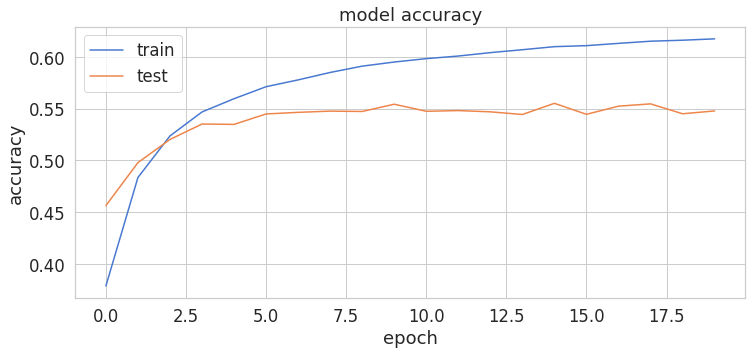

In [17]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

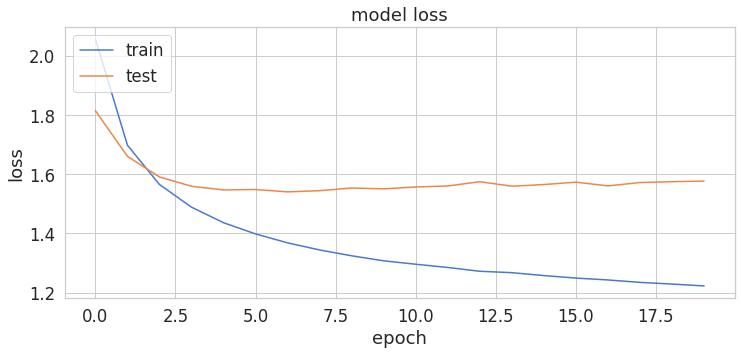

In [18]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [19]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
    return x

La pieza de código (arriba) se utiliza para preparar tensor utilizando partiendo del valor SEQUENCE_LENGTH (longitud de la secuencia/enunciado), tomando en cuenta la lista char_indices.

In [20]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [22]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [23]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

A través de la función predict_completions se realizará la predicción de la palabra, utilizando a su vez las funciones predict_completion y sample.

* sample. Regresará un arreglo con las probabilidades de la palabra más probable a ser predicha
* predict_completion. Recibe la entrada de la predicción hasta el primer espacio, en caso de que la palabra esté incompleta retornará el resto de la palabra.

In [24]:
quotes = [
    "El brutal encuentro duró sólo algunos instantes.",
    "Para eso había entrado él en la Guardia Real.",
    "Con qué elocuencia sabía hablar a sus compañeros para decidirles a que desenvainaran su espada contra el Gobierno",
    "Cuatro batallones de la Guardia Real salieron aquella misma noche de Madrid, mandados por oficiales jóvenes y de poca graduación, pues el que más, era capitán.",
    "Se esperaban graves acontecimientos para dentro de breves horas."
]

### <a id='pruebas'>Modelo: Pruebas</a>


In [25]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

el brutal encuentro duró sólo algunos in
['stantes, ', 'teresas ', 'formes ', 'distaleras ', 'vidares ']

para eso había entrado él en la guardia 
['de ', 'y ', 'se ', 'con ', 'para ']

con qué elocuencia sabía hablar a sus co
['legios ', 'mpañeros ', 'rres ', 'ntempas ', 'sas ']

cuatro batallones de la guardia real sal
['iendo ', 'dado ', 'ona. ', 'ón ', 'taba ']

se esperaban graves acontecimientos para
[' algunos ', 'n ', 'chando ', 's ', 'l ']



### <a id='conclusiones'>Conclusiones</a>

Con el propósito de dar a conocer el estado actual del Procesamiento del Lenguaje Natural se han definido, de forma muy concisa, los principales conceptos y técnicas asociados a esta disciplina, que además se ha desarrollado a lo largo de este proyecto escolar.

Así mismo, se ha comprobado que el PLN es una disciplina viva y en pleno desarrollo, con multitud de retos que superar fruto de la ambigüedad subyacente al lenguaje natural. El empleo del lenguaje le permite al hombre trasmitir sus conocimientos, sentimientos, sensaciones, emociones, y estados de ánimo, por lo que han sido varios los sistemas informáticos inteligentes que se han desarrollado y continuan en evolución continua que emplean el procesamiento del lenguaje natural, para una mayor comprensión y mejoría en el ámbito de las tecnologías de información.